In [1]:
%load_ext autoreload
%autoreload 2

# to enable imports from parent package
import sys
import os
from pathlib import Path
parent_dir = Path(os. getcwd()).parent.absolute()
sys.path.append(str(parent_dir))

import torch
import numpy as np
import os.path as osp
import pandas as pd
import seaborn as sns

from plots import aggregate_over_splits, remove_unused_categories, palette, model_types, group, remove_top_percentage, groupby_to_table, rename_col, concatenate, append_model_type, compute_baseline_score
from attacks.data_recorder import compute_regression_metrics

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Liberation Sans']})
import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt



device = ('cuda' if torch.cuda.is_available() else
          'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')


plots_dir = 'output'
dataset_name = "IMDB-BINARY"

Device: cuda


In [2]:
from tqdm import tqdm
from run_attacks import all_tasks

results_directory = '../results/'

# tasks_to_load = ["original", "bruteforce"]
# filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
# attack_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items()}

# attack_tasks = all_tasks

def load_data(all_tasks, dataset_name, tasks_to_load=[], sortby=["model", "task", "id"], apply_transform=None):
    data = []

    if tasks_to_load:
        filter_tasks = lambda tasks: {task: val for task, val in tasks.items() if any(t in task for t in tasks_to_load)}
        all_tasks = {model_name: filter_tasks(val) for model_name, val in all_tasks.items() if dataset_name in model_name}

    for model_name, tasks in tqdm(all_tasks.items()):
        # if not dataset_name in model_name:
        #     continue
        model_type = model_name.split("_")[0]
        dataset = model_name.split("_")[1]

        for task_name, task in tasks.items():
            path = osp.join(results_directory, dataset, model_name, f"{task_name}.data")
            if not osp.exists(path):
                continue

            df = pd.read_pickle(path)
            if apply_transform is not None:
                    df = apply_transform(df)
            data.append(df)

    def short_model_names_map(df, prefix_len=1):
        model_names = set(df["model"].values)
        count = {}
        rename_map = {}
        for model_name in model_names:
            prefix = "_".join(model_name.split("_")[:prefix_len])
            if not prefix in count:
                count[prefix] = 0
            rename_map[model_name] = f"{prefix}_{count[prefix]}"
            count[prefix] += 1
        return rename_map

    data = concatenate(data)
    data.sort_values(sortby, inplace=True)
    data = data.reset_index(drop=True)
    model_name_map = short_model_names_map(data)
    data["model"] = data["model"].cat.rename_categories(model_name_map)
    data["model_rep"] = [int(x[-1]) for x in data["model"]]
    data = data[~data["id"].isna()]
    data["id"] = data["id"].astype("int32")

    if (data["is_undirected"] == 0).any():
        mask = data["is_undirected"] == 0
        print("found directed perturbation")
        print(data[mask])
    # assert (data["is_undirected"] == 1).all()

    data["acc"] = 1 - data["missclassified"]

    return data


## Original Data

In [3]:
orig_data = load_data(all_tasks, dataset_name, ["original"])
pd.pivot_table(orig_data[["model_type", "y"]], columns="model_type", aggfunc="count")

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 1953.25it/s]


model_type,GINE,DropGINE,PPGN,SignNet,ESAN,Baseline,MeanAggrGINE
y,500,500,500,500,500,500,500


,model_type,acc,lbl_diff
0,Baseline,$0.632 \pm 0.016$,$0.361 \pm 0.012$
1,DropGINE,$0.72 \pm 0.037$,$0.308 \pm 0.027$
2,ESAN,$0.708 \pm 0.038$,$0.308 \pm 0.023$
3,GINE,$0.684 \pm 0.036$,$0.333 \pm 0.031$
4,PPGN,$0.672 \pm 0.018$,$0.335 \pm 0.015$
5,SignNet,$0.698 \pm 0.015$,$0.402 \pm 0.014$
6,meanGINE,$0.678 \pm 0.03$,$0.343 \pm 0.021$


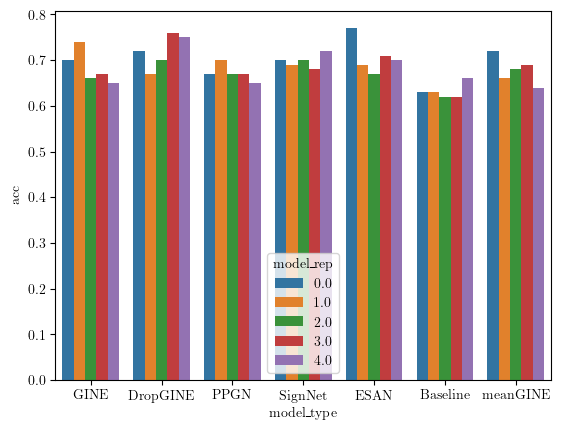

In [4]:
orig_per_model = group(orig_data, ["model"]).mean().reset_index()
append_model_type(orig_per_model)
orig_per_model["budget"] = 0

plot = sns.barplot(data=orig_per_model, x="model_type", y="acc", hue="model_rep")

groupby_to_table(orig_per_model[["model_type", "acc", "lbl_diff"]].groupby("model_type"))

## Bruteforce Data

In [5]:
bf_data = load_data(all_tasks, dataset_name, ["bruteforce"])
pd.pivot_table(bf_data, index=["task", "perturbation"], columns="model_type", aggfunc="count")["y"] # should be 500 everywhere

100%|██████████| 35/35 [00:00<00:00, 1899.45it/s]

model_type               GINE  DropGINE  PPGN  SignNet  ESAN  MeanAggrGINE
task       perturbation                                                   
bruteforce add-edge       500       500   500      500   500           500
           drop-edge      500       500   500      500   500           500

In [6]:
## ADJACENCY PERTURBATION
adjbf_data = remove_unused_categories(bf_data[bf_data["perturbation"].isin(["add-edge", "drop-edge"])])
adjbf_agg = aggregate_over_splits(adjbf_data, group_by=adjbf_data["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "adj_bf"

per_model = group(adjbf_agg, ["model"]).mean().reset_index()
append_model_type(per_model)
per_model = per_model.merge(orig_per_model[["model", "acc", "lbl_diff"]].rename(columns={'acc': 'orig_acc', 'lbl_diff': 'orig_lbl_diff'}), on="model")
per_model["delta_acc"] = per_model["orig_acc"] - per_model["acc"]
per_model["delta_lbl_diff"] = per_model["lbl_diff"] - per_model["orig_lbl_diff"]

groupby_to_table(per_model[["model_type", "acc", "delta_acc", "lbl_diff", "delta_lbl_diff"]].groupby("model_type"))

,model_type,acc,delta_acc,lbl_diff,delta_lbl_diff
0,DropGINE,$0.434 \pm 0.062$,$0.286 \pm 0.089$,$0.54 \pm 0.057$,$0.231 \pm 0.082$
1,ESAN,$0.458 \pm 0.026$,$0.25 \pm 0.021$,$0.516 \pm 0.023$,$0.208 \pm 0.031$
2,GINE,$0.496 \pm 0.032$,$0.188 \pm 0.065$,$0.495 \pm 0.033$,$0.162 \pm 0.06$
3,PPGN,$0.502 \pm 0.03$,$0.17 \pm 0.041$,$0.473 \pm 0.009$,$0.138 \pm 0.022$
4,SignNet,$0.598 \pm 0.06$,$0.1 \pm 0.06$,$0.459 \pm 0.043$,$0.057 \pm 0.045$
5,meanGINE,$0.456 \pm 0.043$,$0.222 \pm 0.056$,$0.552 \pm 0.036$,$0.209 \pm 0.056$


In [7]:
table = pd.pivot_table(adjbf_agg, index=["perturbation"], columns="model_type", aggfunc="count")["y"] / 500
table = table[["GINE", "SignNet", "DropGINE", "ESAN", "PPGN"]]
table.style.format('{:,.1%}'.format)

model_type,GINE,SignNet,DropGINE,ESAN,PPGN
perturbation,,,,,
add-edge,39.2%,47.0%,43.6%,33.6%,42.6%
drop-edge,60.8%,53.0%,56.4%,66.4%,57.4%


## AdjPGD

In [8]:
adjpgd_data = load_data(all_tasks, dataset_name, ["adjpgd"])
pd.pivot_table(adjpgd_data, index=["task"], columns="model_type", aggfunc="count")["y"] # each entry should have 5*5*100=2500 values

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 1022.36it/s]


model_type,GINE,DropGINE,PPGN,SignNet,ESAN,MeanAggrGINE
task,,,,,,
adjpgd_abs,2500,2500,2500,2500,2500,2500
adjpgd_rel,2500,2500,2500,2500,2500,2500


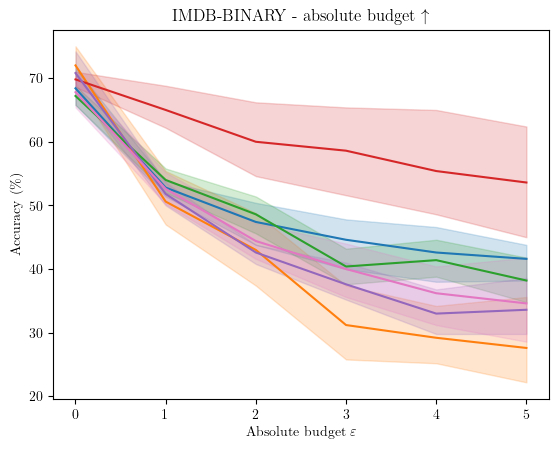

In [9]:
adjpgd_abs_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_abs"])]).copy()

per_model = group(adjpgd_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.title("IMDB-BINARY - absolute budget $\\uparrow$")
plot.set_xticks([i for i in range(6)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_adjpgd_acc_abs.pgf"), bbox_inches='tight')

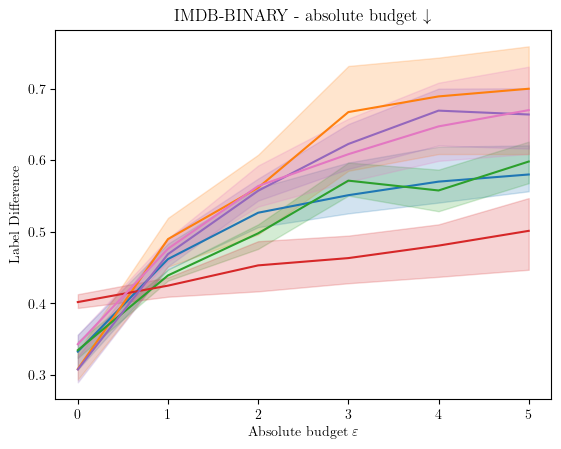

In [10]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.title("IMDB-BINARY - absolute budget $\\downarrow$")
plot.set_xticks([i for i in range(6)])
plt.legend([], [], frameon=False)
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_adjpgd_diff_abs.pgf"), bbox_inches='tight')

In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.pivot_table(per_model[["model", "budget", "expected_budget", "successful_samples"]], values="expected_budget", index="budget", columns="model", aggfunc="mean")

model,DropGINE_0,DropGINE_1,DropGINE_2,DropGINE_3,DropGINE_4,ESAN_0,ESAN_1,ESAN_2,ESAN_3,ESAN_4,GINE_0,GINE_1,GINE_2,GINE_3,GINE_4,MeanAggrGINE_0,MeanAggrGINE_1,MeanAggrGINE_2,MeanAggrGINE_3,MeanAggrGINE_4,PPGN_0,PPGN_1,PPGN_2,PPGN_3,PPGN_4,SignNet_0,SignNet_1,SignNet_2,SignNet_3,SignNet_4
budget,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,0.613175,0.658453,0.979997,0.969996,0.467225,0.212555,0.979990,0.959984,0.949988,0.888730,0.570110,0.889992,0.686220,0.385145,0.551203,0.989981,0.382482,0.375346,0.979978,0.979968,0.900017,0.879993,0.267676,0.899963,0.869991,0.870005,0.389974,0.779982,0.870033,0.0
2.0,1.940004,0.802703,1.726462,1.939985,1.959976,1.724802,1.448152,1.853007,1.911592,1.800015,1.800005,1.779986,1.255684,1.799986,1.799980,1.980003,1.799994,1.939992,1.960026,1.959978,1.799992,1.759990,1.959971,1.799967,1.739990,1.740023,0.779991,1.560009,1.739998,0.0
3.0,2.745255,2.937171,2.713455,2.564031,1.801420,2.598576,2.939983,2.850035,2.789976,2.573093,2.699986,2.669998,2.582162,2.227443,2.266725,2.969997,1.981856,2.910007,2.530467,2.775803,2.438234,2.545825,2.236394,2.699973,2.221920,2.609995,1.169997,2.339983,2.610017,0.0
4.0,3.880013,3.920018,2.916138,3.387982,3.277036,3.480013,3.567553,2.729303,3.839965,3.599992,1.901562,3.553076,2.658482,3.303693,3.600022,3.960014,2.646152,3.880003,3.919987,3.919999,3.600001,3.519993,3.676769,3.599985,3.479188,3.510002,1.559987,3.120013,3.479982,0.0
5.0,4.350686,4.899996,4.900002,4.753031,4.899983,3.064646,4.849988,4.799990,4.849977,4.258311,4.499974,4.449978,2.526928,4.499993,4.492937,4.950000,4.499972,4.849997,4.899982,4.900025,4.499983,3.680453,4.899984,3.262338,4.283754,4.380014,1.949970,3.899980,4.349986,0.0


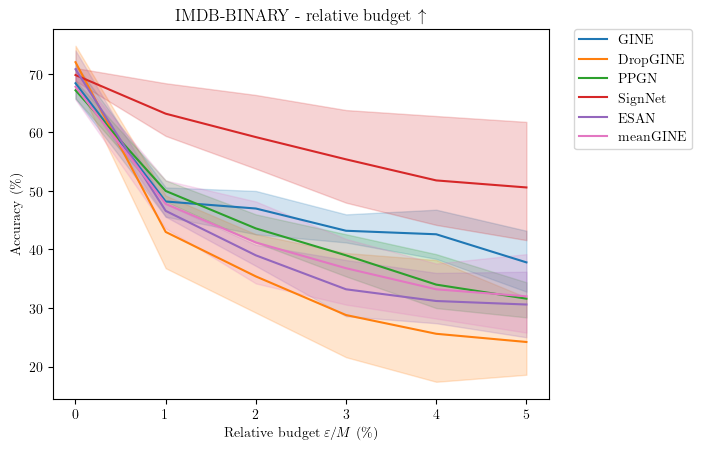

In [12]:
adjpgd_rel_data = remove_unused_categories(adjpgd_data[adjpgd_data["task"].isin(["adjpgd_rel"])]).copy()

per_model = group(adjpgd_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(per_model)

per_model = pd.concat([per_model, orig_per_model]).reset_index()
per_model = remove_unused_categories(per_model[per_model["model_type"]!="Baseline"])
per_model = rename_col(per_model, "model_type", "model type")
per_model = rename_col(per_model, "acc", "accuracy")
per_model["accuracy"] = 100*per_model["accuracy"]

plot = sns.lineplot(data=per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.title("IMDB-BINARY - relative budget $\\uparrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_adjpgd_acc_rel.pgf"), bbox_inches='tight')

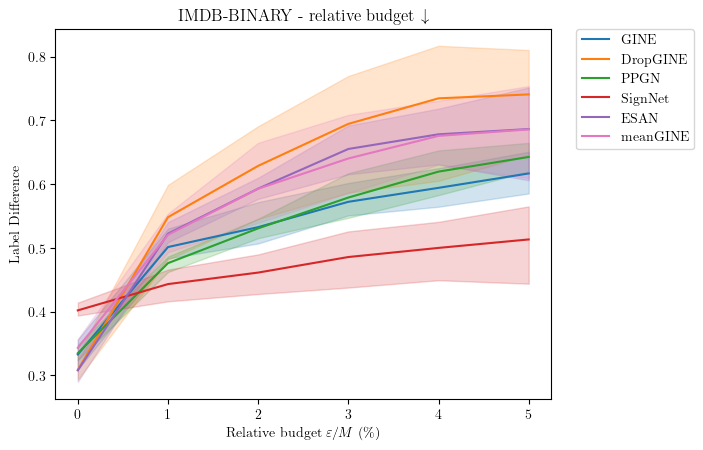

In [13]:
plot = sns.lineplot(data=per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.title("IMDB-BINARY - relative budget $\\downarrow$")
plot.set_xticks([i/100 for i in range(6)])
plot.set_xticklabels([f"{i}" for i in range(6)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_adjpgd_diff_rel.pgf"), bbox_inches='tight')

## Random Perturbations

In [14]:
def reduce_data(df):
    groupby = ["model", "task", "budget"]
    df["count"] = df.groupby(groupby)['y'].transform('size')

    per_model = group(df, groupby).mean().reset_index()
    append_model_type(per_model)
    return per_model

tasks = ["add_rdm_undir_edges", "drop_rdm_undir_edges", "rewire_rdm_undir_edges", "rdm_node_attr_change", "rdm_edge_attr_change"]
rdm_data = load_data(all_tasks, dataset_name, tasks, apply_transform=reduce_data)
assert (rdm_data["count"]==500).all()

baseline_data = orig_data[orig_data["model_type"]=="Baseline"]
baseline_acc = baseline_data["acc"].mean()
baseline_lbl_diff = baseline_data["lbl_diff"].mean()
baseline_acc, baseline_lbl_diff

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:01<00:00, 20.18it/s]


(0.632, 0.36112389233216163)

,model_type,accuracy,lbl_diff
0,DropGINE,$0.498 \pm 0.062$,$0.254 \pm 0.122$
1,ESAN,$0.53 \pm 0.297$,$0.263 \pm 0.135$
2,GINE,$0.472 \pm 0.183$,$0.159 \pm 0.175$
3,PPGN,$0.363 \pm 0.123$,$0.129 \pm 0.093$
4,SignNet,$0.765 \pm 0.247$,$0.0 \pm 0.0$
5,meanGINE,$0.245 \pm 0.185$,$0.074 \pm 0.106$


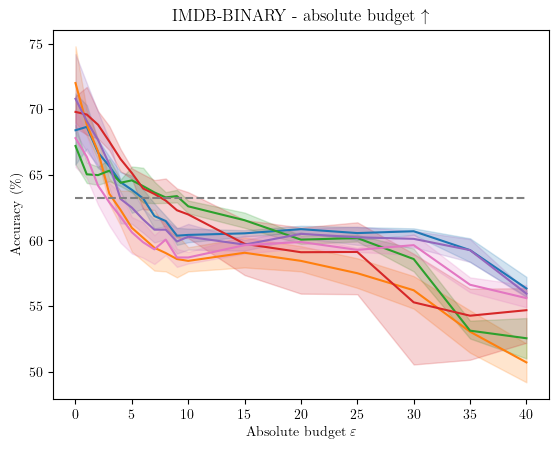

In [15]:
## ADJACENCY - ABS
adjrdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_abs", "drop_rdm_undir_edges_abs"])]).copy()
adjrmd_per_model = group(adjrdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")
adjrmd_per_model = rename_col(adjrmd_per_model, "acc", "accuracy")
adjrmd_per_model["accuracy"] = 100*adjrmd_per_model["accuracy"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-BINARY - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmadj_acc_abs.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

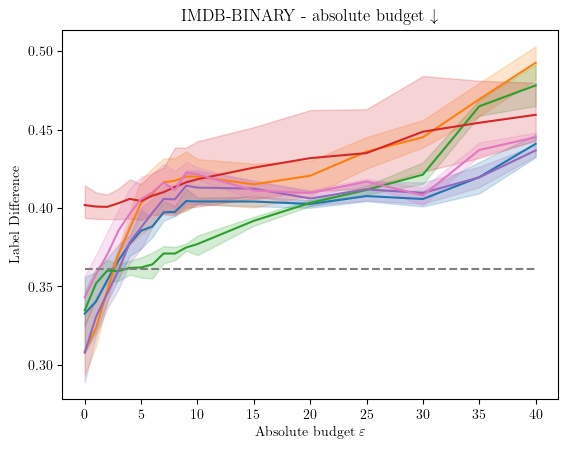

In [16]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-BINARY - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmadj_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,accuracy,lbl_diff
0,DropGINE,$1.154 \pm 1.466$,$0.367 \pm 0.08$
1,ESAN,$0.464 \pm 0.243$,$0.305 \pm 0.161$
2,GINE,$0.317 \pm 0.174$,$0.179 \pm 0.182$
3,PPGN,$2.572 \pm 0.947$,$1.771 \pm 0.964$
4,SignNet,$5.309 \pm 3.056$,$0.005 \pm 0.011$
5,meanGINE,$0.179 \pm 0.128$,$0.072 \pm 0.099$


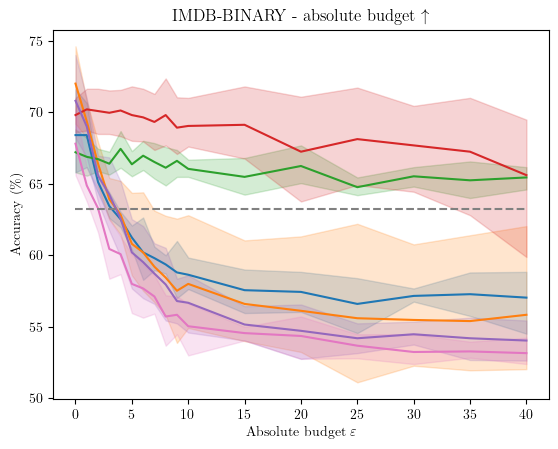

In [17]:
## REWIRE - ABS
rewirerdm_abs_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_abs"])]).copy()
rewirermd_per_model = group(rewirerdm_abs_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")
rewirermd_per_model = rename_col(rewirermd_per_model, "acc", "accuracy")
rewirermd_per_model["accuracy"] = 100*rewirermd_per_model["accuracy"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="accuracy", hue="model type", palette=palette) # linestyle=':', 
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-BINARY - absolute budget $\\uparrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Accuracy (\%)')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmrewire_acc_abs.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

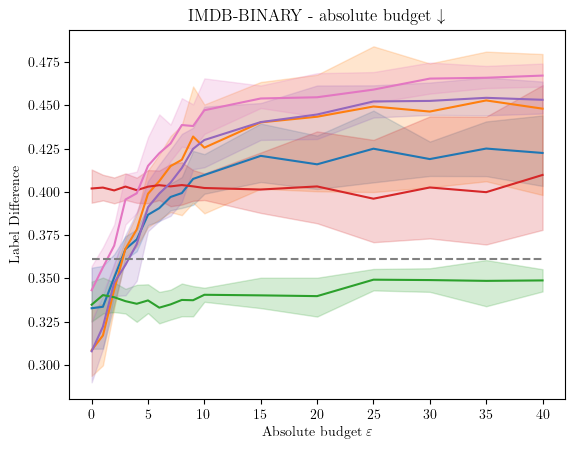

In [18]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette) # linestyle=':', 
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-BINARY - absolute budget $\\downarrow$")
plot.set_xticks([i*5 for i in range(9)])
plt.xlabel('Absolute budget $\\varepsilon$')
plt.ylabel('Label Difference')
plt.legend([], [], frameon=False)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmrewire_lbl_diff_abs.pgf"), bbox_inches='tight')

,model_type,accuracy,lbl_diff
0,DropGINE,$0.514 \pm 0.151$,$0.236 \pm 0.084$
1,ESAN,$0.548 \pm 0.305$,$0.244 \pm 0.135$
2,GINE,$0.535 \pm 0.191$,$0.186 \pm 0.194$
3,PPGN,$0.492 \pm 0.229$,$0.149 \pm 0.139$
4,SignNet,$0.973 \pm 0.19$,$0.0 \pm 0.0$
5,meanGINE,$0.264 \pm 0.204$,$0.075 \pm 0.094$


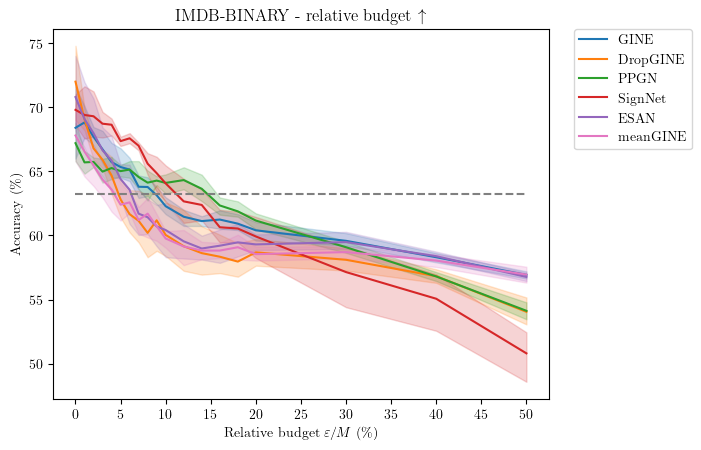

In [19]:
## ADJACENCY - REL
adjrdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["add_rdm_undir_edges_rel", "drop_rdm_undir_edges_rel"])]).copy()
adjrmd_per_model = group(adjrdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(adjrmd_per_model)

adjrmd_per_model = pd.concat([adjrmd_per_model, orig_per_model]).reset_index()
adjrmd_per_model = remove_unused_categories(adjrmd_per_model[adjrmd_per_model["model_type"]!="Baseline"])
adjrmd_per_model = rename_col(adjrmd_per_model, "model_type", "model type")
adjrmd_per_model = rename_col(adjrmd_per_model, "acc", "accuracy")
adjrmd_per_model["accuracy"] = 100*adjrmd_per_model["accuracy"]

plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="accuracy", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-BINARY - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmadj_acc_rel.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(adjrmd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(adjrmd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

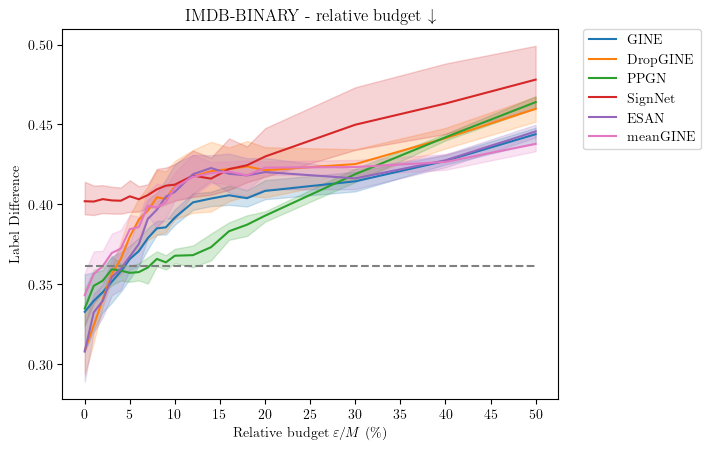

In [20]:
plot = sns.lineplot(data=adjrmd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette)
plt.plot((0, max(adjrmd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-BINARY - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmadj_lbl_diff_rel.pgf"), bbox_inches='tight')

,model_type,accuracy,lbl_diff
0,DropGINE,$1.151 \pm 1.505$,$0.422 \pm 0.206$
1,ESAN,$0.562 \pm 0.372$,$0.375 \pm 0.218$
2,GINE,$0.355 \pm 0.119$,$0.213 \pm 0.192$
3,PPGN,$3.096 \pm 0.878$,$2.164 \pm 0.909$
4,SignNet,$5.497 \pm 2.925$,$0.001 \pm 0.003$
5,meanGINE,$0.205 \pm 0.167$,$0.1 \pm 0.125$


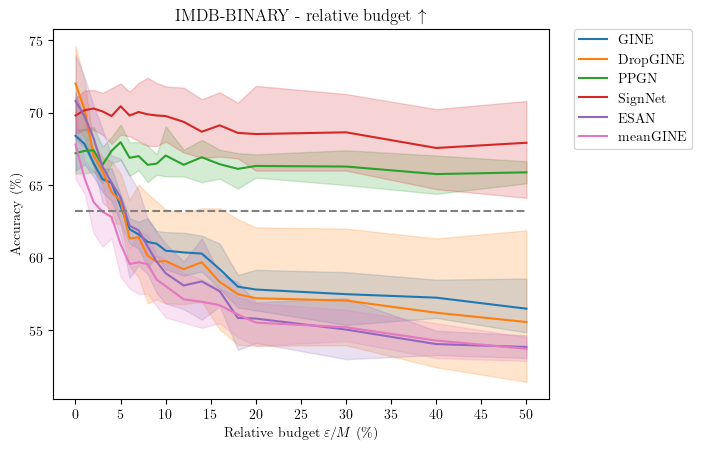

In [21]:
## REWIRE - REL
rewirerdm_rel_data = remove_unused_categories(rdm_data[rdm_data["task"].isin(["rewire_rdm_undir_edges_rel"])]).copy()
rewirermd_per_model = group(rewirerdm_rel_data, ["model", "budget"]).mean().reset_index()
append_model_type(rewirermd_per_model)

rewirermd_per_model = pd.concat([rewirermd_per_model, orig_per_model]).reset_index()
rewirermd_per_model = remove_unused_categories(rewirermd_per_model[rewirermd_per_model["model_type"]!="Baseline"])
rewirermd_per_model = rename_col(rewirermd_per_model, "model_type", "model type")
rewirermd_per_model = rename_col(rewirermd_per_model, "acc", "accuracy")
rewirermd_per_model["accuracy"] = 100*rewirermd_per_model["accuracy"]

plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="accuracy", hue="model type", palette=palette) # linestyle=':',
plt.plot((0, max(rewirermd_per_model["budget"])), (100*baseline_acc, 100*baseline_acc), color='gray', linestyle="--")
plt.title("IMDB-BINARY - relative budget $\\uparrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Accuracy (\%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmrewire_acc_rel.pgf"), bbox_inches='tight')

AUC_acc_df = compute_baseline_score(rewirermd_per_model, 100*baseline_acc, "accuracy", below=True)[["model_type", "model", "accuracy"]]
AUC_lbl_diff_df = compute_baseline_score(rewirermd_per_model, baseline_lbl_diff, "lbl_diff", below=False)[["model", "lbl_diff"]]
AUC_lbl_diff_df["lbl_diff"] = 100*AUC_lbl_diff_df["lbl_diff"]
AUC_df = AUC_acc_df.merge(AUC_lbl_diff_df, on="model")
groupby_to_table(AUC_df[["model_type", "accuracy", "lbl_diff"]].groupby("model_type"))

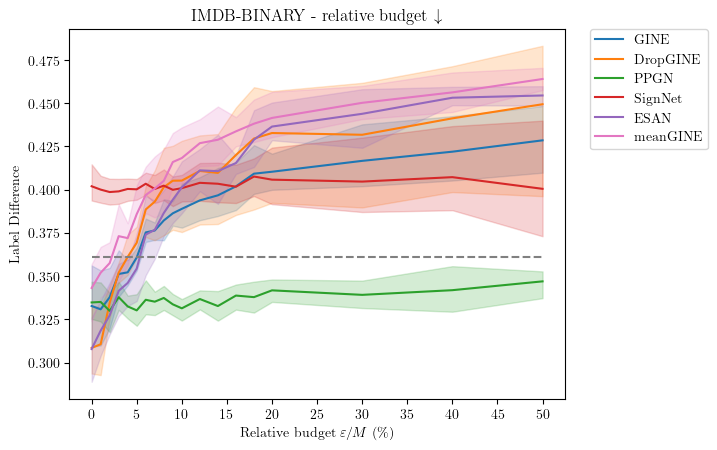

In [22]:
plot = sns.lineplot(data=rewirermd_per_model, x='budget', y="lbl_diff", hue="model type", palette=palette) # linestyle=':',
plt.plot((0, max(rewirermd_per_model["budget"])), (baseline_lbl_diff, baseline_lbl_diff), color='gray', linestyle="--")
plt.title("IMDB-BINARY - relative budget $\\downarrow$")
plot.set_xticks([i*5/100 for i in range(11)])
plot.set_xticklabels([f"{i*5}" for i in range(11)])
plt.xlabel('Relative budget $\\varepsilon / M$ (\%)')
plt.ylabel('Label Difference')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plot.figure.savefig(osp.join(plots_dir, "IMDB-BINARY_rdmrewire_lbl_diff_rel.pgf"), bbox_inches='tight')

## Comparison between PGD and BruteForce

In [24]:
## ADJACENCY COMPARISON
adjpgd_abs_agg = aggregate_over_splits(adjpgd_abs_data, group_by=adjpgd_abs_data["repeat"], shared_cols=["model", "id", "budget"], target_col="lbl_diff")
adjpgd_abs_agg["task_type"] = "adj_pgd_abs"
adjpgd_df = adjpgd_abs_agg[adjpgd_abs_agg["budget"]==1][["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'pgd_lbl_diff'})

adjbf_data_ = remove_unused_categories(adjbf_data[adjbf_data["perturbation"].isin(["add-edge", "drop-edge"])]).copy()
adjbf_agg = aggregate_over_splits(adjbf_data_, group_by=adjbf_data_["task"], shared_cols=["model", "id", "perturbation"], target_col="lbl_diff")
adjbf_agg = aggregate_over_splits(adjbf_agg, group_by=adjbf_agg["perturbation"], shared_cols=["model", "id"], target_col="lbl_diff")
adjbf_agg["task_type"] = "bf"
bf_df = adjbf_agg[["model", "id", "lbl_diff", "pred"]].rename(columns={'lbl_diff': 'bf_lbl_diff'})

adj_comparison_df = adjpgd_df.merge(bf_df, on=["model", "id"])
append_model_type(adj_comparison_df)
adj_comparison_df["better"] = adj_comparison_df["pgd_lbl_diff"] > adj_comparison_df["bf_lbl_diff"] - 1e-05
adj_comparison_df["lbl_diff_gap"] = adj_comparison_df["bf_lbl_diff"] - adj_comparison_df["pgd_lbl_diff"]

print(adj_comparison_df.groupby(by="model_type").count()["id"])

per_model = group(adj_comparison_df, ["model"]).mean().reset_index()
append_model_type(per_model)
groupby_to_table(per_model[["model_type", "lbl_diff_gap", "better"]].groupby("model_type"))

model_type
DropGINE    500
ESAN        500
GINE        500
PPGN        500
SignNet     500
meanGINE    500
Name: id, dtype: int64


,model_type,lbl_diff_gap,better
0,DropGINE,$0.05 \pm 0.013$,$0.344 \pm 0.035$
1,ESAN,$0.047 \pm 0.004$,$0.384 \pm 0.089$
2,GINE,$0.033 \pm 0.013$,$0.556 \pm 0.037$
3,PPGN,$0.033 \pm 0.005$,$0.536 \pm 0.038$
4,SignNet,$0.034 \pm 0.036$,$0.514 \pm 0.232$
5,meanGINE,$0.076 \pm 0.025$,$0.464 \pm 0.063$
